## Experimentation

#### Enhancing Tournament Predictions through Composite Ranking



In sports tournaments, accurately predicting match outcomes and assessing team strengths are crucial for fans, analysts, and stakeholders. Traditional methods often rely solely on seeds ranking, which assigns initial rankings to teams based on past performance. However, to improve the accuracy of predictions and provide a more comprehensive assessment, we propose the use of composite ranking, which combines multiple ranking methods, including Elo rankings and systems rankings.



**Definitions:**

*Seeds Ranking:* Initial rankings assigned to teams based on past performance or seeding rules. Each team is initially assigned a seed based on its performance in the previous season or seeding rules.


*Elo Rankings:* Numerical ratings assigned to teams based on their performance in previous matches, adjusted after each match. Elo ratings are calculated for each team based on historical match data and adjusted after each match to reflect current performance levels.


*Systems Ranking:* Rankings generated by statistical or mathematical models that analyze various factors to predict outcomes or rank participants. Various statistical models and algorithms are utilized to predict match outcomes and rank teams based on factors such as past performance, player statistics, and team composition.


*Composite Ranking:* A combined ranking score that integrates multiple individual rankings or metrics, providing a comprehensive assessment of team strength. The composite ranking is calculated by combining the mean ordinal ranking of the top four systems and the Elo ranking using a weighted averaging approach. This provides a balanced assessment by incorporating both Elo ratings and predictions from multiple systems.



#### Example Calculation:
##### Team A: 
*Elo rating* = 2000, 

*Mean ordinal ranking*: 3 from top four systems

*Composite ranking:*  (Elo rating * 0.6) + (Mean ordinal ranking * 0.4) = (2000 * 0.6) + (3 * 0.4) = 1200 + 1.2 = 1201.2.


### Preparation
Import packages and load in initial datasets

In [2]:
import pandas as pd
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn import model_selection 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_seeds = pd.read_csv("MNCAATourneySeeds.csv")
df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")

In [4]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [5]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


### Seed Based Logistic Regression
Using just seeding the predict winner and confidence, use this as baseline model

In [6]:
# Convert seed to int
df_seeds["Seed_int"] = df_seeds["Seed"].str[1:3]
df_seeds["Seed_int"] = df_seeds["Seed_int"].apply(pd.to_numeric)
df_seeds.head()

,Season,Seed,TeamID,Seed_int
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [7]:
# Drop unnecessary columns
df_seeds.drop(labels=["Seed"], inplace=True, axis=1)
df_tour.drop(
    labels=["DayNum", "WScore", "LScore", "WLoc", "NumOT"], inplace=True, axis=1
)

In [8]:
df_seeds.head()

,Season,TeamID,Seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [9]:
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [10]:
# Merge dataframes
df_winseeds = df_seeds.rename(columns={"TeamID": "WTeamID", "Seed_int": "WSeed"})
df_lossseeds = df_seeds.rename(columns={"TeamID": "LTeamID", "Seed_int": "LSeed"})
df_dummy = pd.merge(
    left=df_tour, right=df_winseeds, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=["Season", "LTeamID"])
df_concat["SeedDiff"] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [11]:
# Create training data set
df_wins = pd.DataFrame()
df_wins["Season"] = df_concat["Season"]
df_wins["SeedDiff"] = df_concat["SeedDiff"]
df_wins["Result"] = 1

df_losses = pd.DataFrame()
df_losses["Season"] = df_concat["Season"]
df_losses["SeedDiff"] = -df_concat["SeedDiff"]
df_losses["Result"] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,SeedDiff,Result
0,1985,1,1
1,1985,5,1
2,1985,-15,1
3,1985,1,1
4,1985,-11,1


Log Loss: 0.6056187331235057
Confusion Matrix: 
[[213 121]
 [ 99 235]] 

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       334
           1       0.66      0.70      0.68       334

    accuracy                           0.67       668
   macro avg       0.67      0.67      0.67       668
weighted avg       0.67      0.67      0.67       668



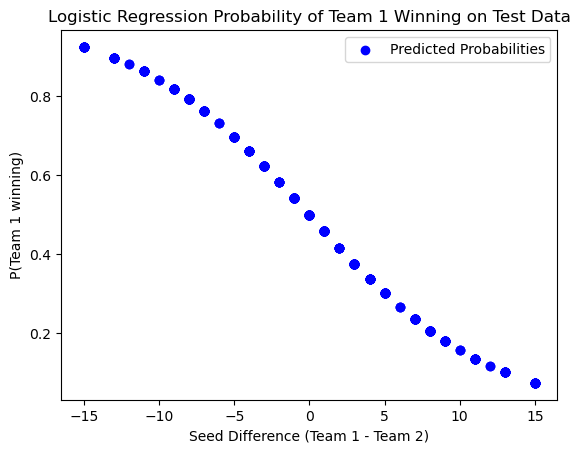

In [12]:
df_train = df_predictions.loc[df_predictions["Season"] < 2018]
df_test = df_predictions.loc[df_predictions["Season"] >= 2018]

X_train = df_train["SeedDiff"].values.reshape(-1, 1)
Y_train = df_train["Result"].values

X_test = df_test["SeedDiff"].values.reshape(-1, 1)
Y_test = df_test["Result"].values

logreg = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf.fit(X_train, Y_train)

Y_pred_proba = clf.predict_proba(X_test)[:, 1]
Y_pred = clf.predict(X_test)
df_test["Elo_Pred"] = Y_pred
df_test.tail()
score1 = log_loss(Y_test, Y_pred_proba)
print("Log Loss:", score1)
print("Confusion Matrix: ")
print(confusion_matrix(Y_test, Y_pred), "\n")
print(classification_report(Y_test, Y_pred))

plt.scatter(X_test, Y_pred_proba, color="blue", label="Predicted Probabilities")
plt.xlabel("Seed Difference (Team 1 - Team 2)")
plt.ylabel("P(Team 1 winning)")
plt.title("Logistic Regression Probability of Team 1 Winning on Test Data")
plt.legend()
plt.show()

### Average Ranking Based Logistic Regression Model

In [13]:
df_massey = pd.read_csv("MMasseyOrdinals.csv")

In [14]:
df_massey.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [15]:
# Create composite final rankings
final_day = 133
df_final_rankings = df_massey.loc[df_massey["RankingDayNum"] == final_day]
df_final_rankings = df_final_rankings.groupby(["Season", "TeamID"])[
    "OrdinalRank"
].mean()
df_final_rankings = df_final_rankings.reset_index()
df_final_rankings.rename(columns={"OrdinalRank": "Avg. Rank"}, inplace=True)

In [16]:
df_final_rankings.head()

,Season,TeamID,Avg. Rank
0,2003,1102,156.03125
1,2003,1103,168.00000
2,2003,1104,38.03125
3,2003,1105,308.96875
4,2003,1106,262.68750


In [17]:
df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(labels=["WLoc", "NumOT"], inplace=True, axis=1)
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


In [18]:
# Join tournament results
df_win_ranks = df_final_rankings.rename(
    columns={"TeamID": "WTeamID", "Avg. Rank": "WAvgRank"}
)
df_loss_ranks = df_final_rankings.rename(
    columns={"TeamID": "LTeamID", "Avg. Rank": "LAvgRank"}
)
df_dummy = pd.merge(
    left=df_tour, right=df_win_ranks, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=["Season", "LTeamID"])
df_concat["ScoreDiff"] = df_concat["WScore"] - df_concat["LScore"]
df_concat["RankDiff"] = df_concat["WAvgRank"] - df_concat["LAvgRank"]
df_total = df_concat[
    ["Season", "DayNum", "WTeamID", "LTeamID", "WAvgRank", "LAvgRank", "RankDiff"]
]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,WAvgRank,LAvgRank,RankDiff
0,2003,134,1421,1411,240.343750,239.281250,1.062500
1,2003,136,1112,1436,2.676471,153.125000,-150.448529
2,2003,136,1113,1272,36.000000,21.705882,14.294118
3,2003,136,1141,1166,45.687500,20.735294,24.952206
4,2003,136,1143,1301,36.406250,50.312500,-13.906250


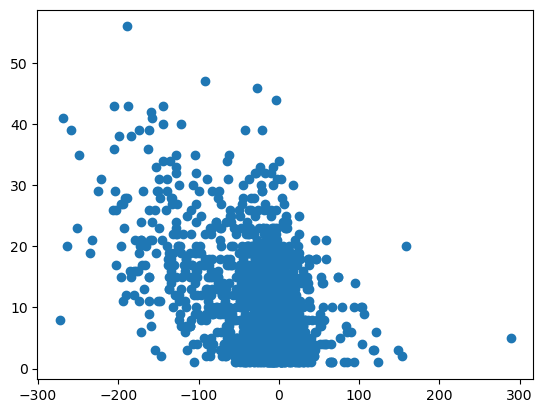

In [19]:
# Is ranking difference correlated with score difference?
plt.scatter(df_concat["RankDiff"], df_concat["ScoreDiff"])

In [20]:
# Create testing and training sets
df_wins = pd.DataFrame()
df_wins["Season"] = df_concat["Season"]
df_wins["RankDiff"] = df_concat["RankDiff"]
df_wins["Result"] = 1

df_losses = pd.DataFrame()
df_losses["Season"] = df_concat["Season"]
df_losses["RankDiff"] = -df_concat["RankDiff"]
df_losses["Result"] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,RankDiff,Result
0,2003,1.062500,1
1,2003,-150.448529,1
2,2003,14.294118,1
3,2003,24.952206,1
4,2003,-13.906250,1


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

# Splitting the data into training and testing sets
df_train = df_predictions.loc[df_predictions["Season"] < 2018]
df_test = df_predictions.loc[df_predictions["Season"] >= 2018]

X_train = df_train["RankDiff"].values.reshape(-1, 1)
Y_train = df_train["Result"].values

X_test = df_test["RankDiff"].values.reshape(-1, 1)
Y_test = df_test["Result"].values

# Training the logistic regression model
logreg = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf.fit(X_train, Y_train)

# Calculating log loss on the test set
Y_pred_proba = clf.predict_proba(X_test)
# log_loss_score = clf.score(X_test, Y_test)
score1 = log_loss(Y_test, Y_pred_proba)

# Predicting on the test set
Y_pred = clf.predict(X_test)

# Printing the log loss score
print("Log Loss:", score1)

# Printing the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

Log Loss: 0.6240327789261104
Confusion Matrix:
[[225 109]
 [109 225]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       334
           1       0.67      0.67      0.67       334

    accuracy                           0.67       668
   macro avg       0.67      0.67      0.67       668
weighted avg       0.67      0.67      0.67       668



### FiveThirtyEight Elo Logistic Regression Implementation

In [22]:
# Homecourt Bonus
HOME_ADVANTAGE = 100
# Learning rate
K = 22

In [23]:
rs = pd.read_csv("MRegularSeasonCompactResults.csv")
rs.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [24]:
# Teams
team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
len(team_ids)

378

In [25]:
# Score lookup dict
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

In [26]:
# New columns to help us iteratively update elos
rs["margin"] = rs.WScore - rs.LScore
rs["w_elo"] = None
rs["l_elo"] = None

In [27]:
# Elo calculation
def elo_pred(elo1, elo2):
    return 1.0 / (10.0 ** (-(elo1 - elo2) / 400.0) + 1.0)


def expected_margin(elo_diff):
    return 7.5 + 0.006 * elo_diff


def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.0) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return (pred, update)

In [28]:
# Check order
assert np.all(rs.index.values == np.array(range(rs.shape[0]))), "Index is out of order."

In [29]:
# Iterate through all games
preds = []
for i in range(rs.shape[0]):

    # Get key data from current row
    w = rs.at[i, "WTeamID"]
    l = rs.at[i, "LTeamID"]
    margin = rs.at[i, "margin"]
    wloc = rs.at[i, "WLoc"]

    # Does either team get a home-court advantage?
    (
        w_ad,
        l_ad,
    ) = (
        0.0,
        0.0,
    )
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w] + w_ad, elo_dict[l] + l_ad, margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    preds.append(pred)

    # Stores new elos in the games dataframe
    rs.loc[i, "w_elo"] = elo_dict[w]
    rs.loc[i, "l_elo"] = elo_dict[l]

In [30]:
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(["Season", "DayNum"], inplace=True)
    d.drop_duplicates(["Season"], keep="last", inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d["season_elo"] = None
    d.loc[w_mask, "season_elo"] = d.loc[w_mask, "w_elo"]
    d.loc[l_mask, "season_elo"] = d.loc[l_mask, "l_elo"]
    out = pd.DataFrame(
        {"team_id": team_id, "season": d.Season, "season_elo": d.season_elo}
    )
    return out

In [31]:
df_list = [final_elo_per_season(rs, i) for i in team_ids]
season_elos = pd.concat(df_list)

In [32]:
season_elos.head()

,team_id,season,season_elo
134286,1101,2014,1317.046906
139681,1101,2015,1201.111852
145038,1101,2016,1213.735772
150369,1101,2017,1233.861895
155760,1101,2018,1295.57557


In [33]:
# Logistic Regression

df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(
    labels=["DayNum", "WLoc", "NumOT", "WScore", "LScore"], inplace=True, axis=1
)

df_win_elos = season_elos.rename(
    columns={"team_id": "WTeamID", "season": "Season", "season_elo": "W_Elo"}
)  #
df_loss_elos = season_elos.rename(
    columns={"team_id": "LTeamID", "season": "Season", "season_elo": "L_Elo"}
)  #
df_dummy = pd.merge(
    left=df_tour, right=df_win_elos, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=["Season", "LTeamID"])
df_concat["Elo_Diff"] = df_concat["W_Elo"] - df_concat["L_Elo"]
df_concat.head()

,Season,WTeamID,LTeamID,W_Elo,L_Elo,Elo_Diff
0,1985,1116,1234,1591.577794,1611.13548,-19.557686
1,1985,1120,1345,1571.383932,1582.630293,-11.246362
2,1985,1207,1250,1748.491322,1430.346043,318.14528
3,1985,1229,1425,1582.036358,1578.096133,3.940226
4,1985,1242,1325,1615.962789,1600.978706,14.984084


In [34]:
# Prediction dataframe
# Create training data set
df_wins = pd.DataFrame()
df_wins["Season"] = df_concat["Season"]
df_wins["Elo_Diff"] = df_concat["Elo_Diff"]
df_wins["Result"] = 1

df_losses = pd.DataFrame()
df_losses["Season"] = df_concat["Season"]
df_losses["Elo_Diff"] = -df_concat["Elo_Diff"]
df_losses["Result"] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,Elo_Diff,Result
0,1985,-19.557686,1
1,1985,-11.246362,1
2,1985,318.14528,1
3,1985,3.940226,1
4,1985,14.984084,1


In [35]:
df_train = df_predictions.loc[df_predictions["Season"] < 2018]
df_test = df_predictions.loc[df_predictions["Season"] >= 2018]

X_train = df_train["Elo_Diff"].values.reshape(-1, 1)
Y_train = df_train["Result"].values

X_test = df_test["Elo_Diff"].values.reshape(-1, 1)
Y_test = df_test["Result"].values

logreg = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf.fit(X_train, Y_train)


Y_pred = clf.predict(X_test)
df_test["Elo_Pred"] = Y_pred
score_1 = log_loss(Y_test, Y_pred)
print("Log Loss:", score_1)

df_test.tail()
print("Confusion Matrix: ")
print(confusion_matrix(Y_test, Y_pred), "\n")
print(classification_report(Y_test, Y_pred))

Log Loss: 11.65483403001393
Confusion Matrix: 
[[226 108]
 [108 226]] 

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       334
           1       0.68      0.68      0.68       334

    accuracy                           0.68       668
   macro avg       0.68      0.68      0.68       668
weighted avg       0.68      0.68      0.68       668



### Select Ranking Systems

In [36]:
df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(
    labels=["DayNum", "WLoc", "NumOT", "WScore", "LScore"], inplace=True, axis=1
)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [37]:
# Get list of all ranking systems
ranking_types = df_massey["SystemName"].unique().tolist()
ranking_types = [
    e
    for e in ranking_types
    if e not in ("MIC", "GC", "RAG", "TOL", "EBB", "BP5", "MPI", "BOW", "CTL")
]
print(ranking_types)

['SEL', 'AP', 'BIH', 'DUN', 'ENT', 'GRN', 'IMS', 'MAS', 'MKV', 'MOR', 'POM', 'RPI', 'SAG', 'SAU', 'SE', 'STR', 'USA', 'WLK', 'WOB', 'BOB', 'DWH', 'ERD', 'ECK', 'BRZ', 'ARG', 'RTH', 'WOL', 'HOL', 'COL', 'DOL', 'GRS', 'HER', 'TSR', 'WTE', 'BD', 'MGY', 'CNG', 'SIM', 'DES', 'JON', 'LYN', 'NOR', 'RM', 'REI', 'ACU', 'BCM', 'CMV', 'SAP', 'DC', 'KLK', 'WIL', 'ROH', 'RIS', 'REN', 'SCR', 'DOK', 'PIG', 'KPK', 'PKL', 'TRX', 'MB', 'JCI', 'PH', 'LYD', 'KRA', 'RTR', 'UCS', 'ISR', 'CPR', 'BKM', 'JEN', 'REW', 'STH', 'SPW', 'RSE', 'PGH', 'CPA', 'RTB', 'HKB', 'BPI', 'TW', 'NOL', 'DC2', 'DCI', 'OMY', 'LMC', 'RT', 'KEL', 'KMV', 'RTP', 'TMR', 'AUS', 'ROG', 'PTS', 'KOS', 'PEQ', 'ADE', 'BNM', 'CJB', 'BUR', 'HAT', 'MSX', 'BBT', '7OT', 'SFX', 'EBP', 'TBD', 'CRO', 'D1A', 'TPR', 'BLS', 'DII', 'KBM', 'TRP', 'LOG', 'SP', 'STF', 'WMR', 'PPR', 'STS', 'UPS', 'SPR', 'MvG', 'TRK', 'BWE', 'HAS', 'FSH', 'DAV', 'KPI', 'FAS', 'MCL', 'HRN', 'RSL', 'SMN', 'DDB', 'INP', 'JRT', 'ESR', 'FMG', 'PRR', 'SMS', 'HKS', 'MUZ', 'OCT', '

In [38]:
# Iterate through each ranking and check log loss
def logreg_type(mytype):
    df_type = df_massey.loc[
        (df_massey["RankingDayNum"] == final_day) & (df_massey["SystemName"] == mytype)
    ]
    df_type = df_type.drop(labels=["RankingDayNum", "SystemName"], axis=1)
    df_type.rename(columns={"OrdinalRank": "Type Rank"}, inplace=True)

    df_win_ranks = df_type.rename(
        columns={"TeamID": "WTeamID", "Type Rank": "WTypeRank"}
    )
    df_loss_ranks = df_type.rename(
        columns={"TeamID": "LTeamID", "Type Rank": "LTypeRank"}
    )
    df_dummy = pd.merge(
        left=df_tour, right=df_win_ranks, how="left", on=["Season", "WTeamID"]
    )
    df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=["Season", "LTeamID"])
    df_concat["RankDiff"] = df_concat["WTypeRank"] - df_concat["LTypeRank"]
    df_total = df_concat[
        ["Season", "WTeamID", "LTeamID", "WTypeRank", "LTypeRank", "RankDiff"]
    ]

    if len(df_total) > 980:
        df_wins = pd.DataFrame()
        df_wins["RankDiff"] = df_total["RankDiff"]
        df_wins["Result"] = 1
        df_losses = pd.DataFrame()
        df_losses["RankDiff"] = -df_total["RankDiff"]
        df_losses["Result"] = 0

        df_predictions = pd.concat((df_wins, df_losses))

        X_train = df_predictions["RankDiff"].values.reshape(-1, 1)
        Y_train = df_predictions["Result"].values
        X_train, Y_train = shuffle(X_train, Y_train)
        if np.isnan(np.sum(X_train)) == False:

            logregtype = LogisticRegression()
            params = {"C": np.logspace(start=-5, stop=5, num=10)}
            clf = GridSearchCV(logregtype, params, scoring="neg_log_loss", refit=True)
            clf.fit(X_train, Y_train)

            print(
                "{} - Best log_loss: {:.4}, with best C: {}".format(
                    mytype, clf.best_score_, clf.best_params_["C"]
                )
            )
            return pd.DataFrame(
                {"Type": [mytype], "Log Loss": [clf.best_score_]},
                columns=["Type", "Log Loss"],
            )
        return pd.DataFrame(
            {"Type": [mytype], "Log Loss": [999]}, columns=["Type", "Log Loss"]
        )
    return pd.DataFrame(
        {"Type": [mytype], "Log Loss": [999]}, columns=["Type", "Log Loss"]
    )

In [39]:
df_type_scores = pd.DataFrame(columns=["Type", "Log Loss"])
for mytype in ranking_types:
    df_type_scores = df_type_scores._append(logreg_type(mytype))

SEL - Best log_loss: -0.5765, with best C: 0.0001291549665014884
BIH - Best log_loss: -0.5776, with best C: 0.0016681005372000592
DUN - Best log_loss: -0.5854, with best C: 0.0001291549665014884
MAS - Best log_loss: -0.5806, with best C: 0.0001291549665014884
MOR - Best log_loss: -0.5651, with best C: 0.0016681005372000592
POM - Best log_loss: -0.5656, with best C: 0.0016681005372000592
RPI - Best log_loss: -0.5691, with best C: 0.0001291549665014884
SAG - Best log_loss: -0.5646, with best C: 0.0016681005372000592
WLK - Best log_loss: -0.5643, with best C: 0.0016681005372000592
WOB - Best log_loss: -0.5799, with best C: 0.0001291549665014884
RTH - Best log_loss: -0.5667, with best C: 0.0001291549665014884
WOL - Best log_loss: -0.5705, with best C: 0.0016681005372000592
COL - Best log_loss: -0.5788, with best C: 0.0001291549665014884
DOL - Best log_loss: -0.5728, with best C: 0.0001291549665014884
CNG - Best log_loss: -0.5548, with best C: 0.0001291549665014884
WIL - Best log_loss: -0.5

In [40]:
df_type_scores = df_type_scores.loc[df_type_scores["Log Loss"] != 999]
df_type_scores.sort_values(by="Log Loss", ascending=False, inplace=True)
df_type_scores

,Type,Log Loss
0,CNG,-0.554803
0,WLK,-0.564343
0,SAG,-0.564649
0,MOR,-0.565118
0,POM,-0.565607
0,RTH,-0.566672
0,RPI,-0.569050
0,WOL,-0.570521
0,DOL,-0.572776
0,DOK,-0.576105


### Final Feature Engineering
We have tried to determine the accuracy on different rankings, including Elo which is the most popular ranking metrics in sports winner estimation. We are willing to make a composite ranking that combines these rankings and tune it for our final 2024 predictions:


In [41]:
# Pull various system rankings
df_topranks = season_elos.loc[:, season_elos.columns != "Elo"]
df_topranks = df_topranks.rename(columns={"team_id": "Team_ID", "season": "Season"})

df_temp = df_massey.loc[
    (df_massey["RankingDayNum"] == final_day) & (df_massey["SystemName"] == "SAG")
]
df_temp = df_temp.drop(labels=["RankingDayNum", "SystemName"], axis=1)
df_temp.rename(columns={"OrdinalRank": "SAG", "TeamID": "Team_ID"}, inplace=True)

df_temp2 = df_massey.loc[
    (df_massey["RankingDayNum"] == final_day) & (df_massey["SystemName"] == "WLK")
]
df_temp2 = df_temp2.drop(labels=["RankingDayNum", "SystemName"], axis=1)
df_temp2.rename(columns={"OrdinalRank": "WLK", "TeamID": "Team_ID"}, inplace=True)

df_temp3 = df_massey.loc[
    (df_massey["RankingDayNum"] == final_day) & (df_massey["SystemName"] == "POM")
]
df_temp3 = df_temp3.drop(labels=["RankingDayNum", "SystemName"], axis=1)
df_temp3.rename(columns={"OrdinalRank": "POM", "TeamID": "Team_ID"}, inplace=True)

df_temp4 = df_massey.loc[
    (df_massey["RankingDayNum"] == final_day) & (df_massey["SystemName"] == "MOR")
]
df_temp4 = df_temp4.drop(labels=["RankingDayNum", "SystemName"], axis=1)
df_temp4.rename(columns={"OrdinalRank": "MOR", "TeamID": "Team_ID"}, inplace=True)

df_topranks = pd.merge(
    left=df_topranks, right=df_temp, how="left", on=["Season", "Team_ID"]
)
df_topranks = pd.merge(
    left=df_topranks, right=df_temp2, how="left", on=["Season", "Team_ID"]
)
df_topranks = pd.merge(
    left=df_topranks, right=df_temp3, how="left", on=["Season", "Team_ID"]
)
df_topranks = pd.merge(
    left=df_topranks, right=df_temp4, how="left", on=["Season", "Team_ID"]
)

In [42]:
# Mean of all four systems
df_topranks["MeanRank"] = (
    df_topranks["SAG"] + df_topranks["WLK"] + df_topranks["POM"] + df_topranks["MOR"]
) / 4
df_topranks.dropna(inplace=True)
df_topranks.head()

,Team_ID,Season,season_elo,SAG,WLK,POM,MOR,MeanRank
0,1101,2014,1317.046906,346.0,330.0,348.0,349.0,343.25
1,1101,2015,1201.111852,336.0,332.0,332.0,346.0,336.50
2,1101,2016,1213.735772,320.0,304.0,318.0,311.0,313.25
3,1101,2017,1233.861895,305.0,307.0,300.0,317.0,307.25
4,1101,2018,1295.57557,276.0,261.0,262.0,265.0,266.00


In [43]:
# Join with tournament dataframe

df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(labels=["WLoc", "NumOT", "WScore", "LScore"], inplace=True, axis=1)
df_topranks.drop(labels=["SAG", "WLK", "POM", "MOR"], inplace=True, axis=1)

df_win_elos = df_topranks.rename(
    columns={"Team_ID": "WTeamID", "MeanRank": "W_MeanRank"}
)
df_loss_elos = df_topranks.rename(
    columns={"Team_ID": "LTeamID", "MeanRank": "L_MeanRank"}
)
df_dummy = pd.merge(
    left=df_tour, right=df_win_elos, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=["Season", "LTeamID"])
df_concat["MeanRank_Diff"] = df_concat["W_MeanRank"] - df_concat["L_MeanRank"]
df_concat.head()

,Season,DayNum,WTeamID,LTeamID,season_elo_x,W_MeanRank,season_elo_y,L_MeanRank,MeanRank_Diff
0,2003,134,1421,1411,1318.061247,259.50,1288.791577,264.50,-5.00
1,2003,136,1112,1436,2051.077363,2.75,1442.803333,160.50,-157.75
2,2003,136,1113,1272,1787.953769,30.00,1833.366259,22.00,8.00
3,2003,136,1141,1166,1663.705965,45.00,1835.575969,24.25,20.75
4,2003,136,1143,1301,1862.127821,39.00,1825.555407,44.00,-5.00


In [44]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins["Season"] = df_concat["Season"]
df_wins["DayNum"] = df_concat["DayNum"]
df_wins["WTeamID"] = df_concat["WTeamID"]
df_wins["LTeamID"] = df_concat["LTeamID"]

df_wins["MeanRank_Diff"] = df_concat["MeanRank_Diff"]
df_wins["Result"] = 1

df_losses = pd.DataFrame()
df_losses["Season"] = df_concat["Season"]
df_losses["DayNum"] = df_concat["DayNum"]
df_losses["WTeamID"] = df_concat["WTeamID"]
df_losses["LTeamID"] = df_concat["LTeamID"]

df_losses["MeanRank_Diff"] = -df_concat["MeanRank_Diff"]
df_losses["Result"] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,MeanRank_Diff,Result
0,2003,134,1421,1411,-5.00,1
1,2003,136,1112,1436,-157.75,1
2,2003,136,1113,1272,8.00,1
3,2003,136,1141,1166,20.75,1
4,2003,136,1143,1301,-5.00,1


In [45]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions["DayNum"] > 135]
len(df_predictions)

2526

In [46]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions["Season"] < 2018]
df_test = df_predictions.loc[df_predictions["Season"] >= 2018]

X_train = df_train["MeanRank_Diff"].values.reshape(-1, 1)
Y_train = df_train["Result"].values

X_test = df_test["MeanRank_Diff"].values.reshape(-1, 1)
Y_test = df_test["Result"].values

logreg = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf2 = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf2.fit(X_train, Y_train)
clf2.score(X_train, Y_train)

-0.5392572805538042

In [47]:
Y_pred1 = clf.predict(X_test)
df_test["MeanRank_Diff_Pred"] = Y_pred1
df_test.tail()

,Season,DayNum,WTeamID,LTeamID,MeanRank_Diff,Result,MeanRank_Diff_Pred
1310,2023,146,1274,1400,-32.75,0,0
1311,2023,146,1361,1166,-8.00,0,0
1312,2023,152,1163,1274,31.75,0,1
1313,2023,152,1361,1194,11.75,0,1
1314,2023,154,1163,1361,15.25,0,1


In [57]:
season_elos = season_elos.rename(
    columns={"team_id": "Team_ID", "season": "Season", "season_elo": "Elo"}
)
df = pd.merge(left=season_elos, right=df_topranks, how="left", on=["Season", "Team_ID"])
df.dropna(inplace=True)


scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df["Elo_Scaled"] = scaler.fit_transform(df["Elo"].values.reshape(-1, 1))
df["MeanRank_Scaled"] = 1 - scaler.fit_transform(df["MeanRank"].values.reshape(-1, 1))


df["Composite Score"] = (0.5 * df["Elo_Scaled"] + (100 * df["MeanRank_Scaled"])) / 5
df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(labels=["WLoc", "NumOT", "WScore", "LScore"], inplace=True, axis=1)
# df.drop(labels=["Elo", "season_elo", "MeanRank"], inplace=True, axis=1)

df_win_elos = df.rename(
    columns={"Team_ID": "WTeamID", "Composite Score": "W_Composite"}
)
df_loss_elos = df.rename(
    columns={"Team_ID": "LTeamID", "Composite Score": "L_Composite"}
)
df_dummy = pd.merge(
    left=df_tour, right=df_win_elos, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=["Season", "LTeamID"])
df_concat["Composite_Diff"] = df_concat["W_Composite"] - df_concat["L_Composite"]
df_total = df_concat[
    [
        "Season",
        "DayNum",
        "WTeamID",
        "LTeamID",
        "W_Composite",
        "L_Composite",
        "Composite_Diff",
    ]
]

df_wins = pd.DataFrame()
df_wins["Season"] = df_concat["Season"]
df_wins["DayNum"] = df_concat["DayNum"]
df_wins["WTeamID"] = df_concat["WTeamID"]
df_wins["LTeamID"] = df_concat["LTeamID"]

df_wins["Composite_Diff"] = df_concat["Composite_Diff"]
df_wins["Result"] = 1

df_losses = pd.DataFrame()
df_losses["Season"] = df_concat["Season"]
df_losses["DayNum"] = df_concat["DayNum"]
df_losses["WTeamID"] = df_concat["WTeamID"]
df_losses["LTeamID"] = df_concat["LTeamID"]

df_losses["Composite_Diff"] = -df_concat["Composite_Diff"]
df_losses["Result"] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions = df_predictions.loc[df_predictions["DayNum"] > 135]

df_train = df_predictions.loc[df_predictions["Season"] < 2018]
df_test = df_predictions.loc[df_predictions["Season"] >= 2018]

X_train = df_train["Composite_Diff"].values.reshape(-1, 1)
Y_train = df_train["Result"].values

X_test = df_test["Composite_Diff"].values.reshape(-1, 1)
Y_test = df_test["Result"].values

logreg = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf3 = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf3

clf3.fit(X_train, Y_train)
clf3.score(X_train, Y_train)

Y_pred3 = clf3.predict(X_test)
df_test["Composite_Diff_Pred"] = Y_pred3
df_test.tail()

filename = "ncaa_tourney1.pkl"
# filename = 'ncaa_tourney2.pkl'
pickle.dump(clf3, open(filename, "wb"))

print("Confusion Matrix: ")
print(confusion_matrix(Y_test, Y_pred3), "\n")
print(classification_report(Y_test, Y_pred3))

Confusion Matrix: 
[[222  96]
 [ 96 222]] 

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       318
           1       0.70      0.70      0.70       318

    accuracy                           0.70       636
   macro avg       0.70      0.70      0.70       636
weighted avg       0.70      0.70      0.70       636



#### Conclusion:


The adoption of composite ranking enhances tournament predictions by integrating multiple ranking methods, including Elo rankings and systems rankings. This approach provides a more accurate and comprehensive assessment of team strengths, surpassing the limitations of relying solely on seeds ranking. By leveraging the strengths of each ranking method, stakeholders can make more informed decisions and improve the overall tournament experience.






